In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import random
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm
import pickle

from joblib import Parallel, delayed
import multiprocessing
from collections import namedtuple
from itertools import count

import cProfile
from datetime import datetime

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

from matplotlib import rc
rc('font',**{'family':'sans-serif'})
rc('text', usetex=False)
#rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
#rc('text.latex',preamble=r'\usepackage[russian]{babel}')
rc('figure', **{'dpi': 300})

/home/maxim_ryazanov/MADE/3Sem/rl/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.autograd import Variable
from torchvision.utils import save_image

import torchvision.datasets as datasets
from torchvision.utils import make_grid

# Pix2Pix

In [3]:
def show_image(tensor):
    plt.figure(figsize=(2,2))
    plt.imshow(tensor.permute(1, 2, 0))

In [27]:
image_size = 256
image_shape = (3, image_size, image_size)

cuda = True if torch.cuda.is_available() else False
print(f"Using cuda {cuda}")
cuda = False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

batch_size = 10

Using cuda True


In [5]:
ds = datasets.ImageFolder(
        "./facades/",
        transform=transforms.Compose(
            [transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    )
dataloader = torch.utils.data.DataLoader(
    ds,
    batch_size=batch_size,
    shuffle=False,
)

In [165]:
for i, (imgs, a) in enumerate(dataloader):
    b = imgs
    c = a
    break

In [166]:
b[:,:,:,256:][1].device

device(type='cpu')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


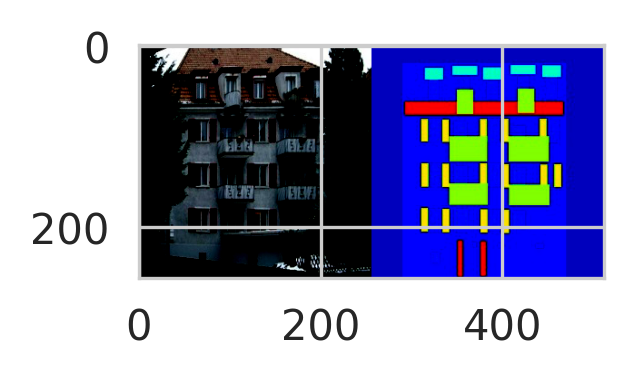

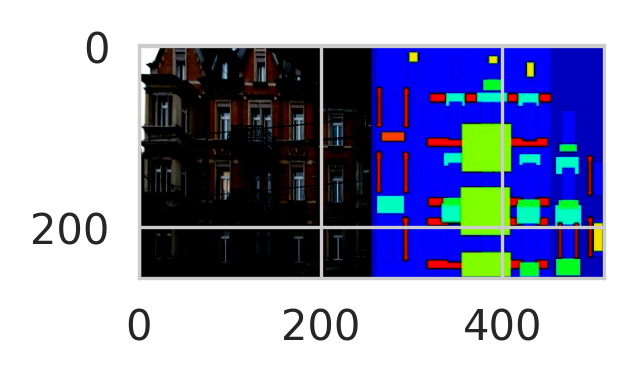

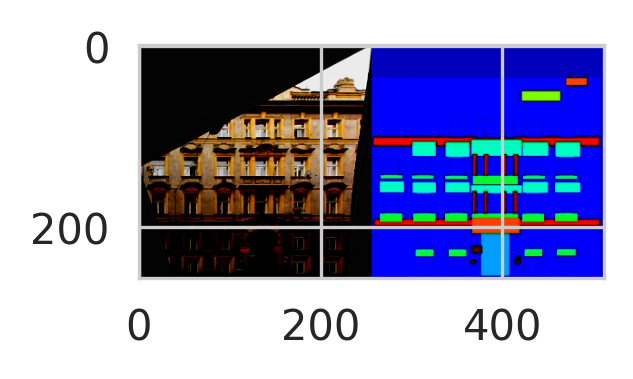

In [78]:

for i in range(3):
    plt.figure(figsize=(2,2))
    plt.imshow(ds[152 + i][0].permute(1, 2, 0))

In [18]:
class UnetGenerator(nn.Module):
    def __init__(self, d=64):
        super(UnetGenerator, self).__init__()
        
        self.conv1 = nn.Sequential( # 128 x 128
            nn.Conv2d(3, d, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.conv2 = nn.Sequential( # 32 x 32
            nn.Conv2d(d, d * 2, 8, 4, 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(d * 2),
        )
        self.conv3 = nn.Sequential( # 8 x 8
            nn.Conv2d(d * 2, d * 4, 8, 4, 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(d * 4),
        )
        self.conv4 = nn.Sequential( # 7 x 7
            nn.Conv2d(d * 4, d * 8, 4, 1, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(d * 8),
        )
        self.conv5 = nn.Sequential( # 1 x 1
            nn.Conv2d(d * 8, d * 8, 7, 1, 0),
            nn.LeakyReLU(0.2, inplace=True),
        )
        
        self.deconv1 = nn.Sequential(
            nn.ConvTranspose2d(d * 8, d * 8, 7, 1, 0),
            nn.BatchNorm2d(d * 8),
            nn.Dropout2d(0.25),
        )
        
        self.deconv2 = nn.Sequential(
            nn.ReLU(),
            nn.ConvTranspose2d(d * 8 * 2, d * 4, 4, 1, 1),
            nn.BatchNorm2d(d * 4),
            nn.Dropout2d(0.25),
        )
        
        self.deconv3 = nn.Sequential(
            nn.ReLU(),
            nn.ConvTranspose2d(d * 4 * 2, d * 2, 8, 4, 2),
            nn.BatchNorm2d(d * 2),
            nn.Dropout2d(0.25),
        )
        
        self.deconv4 = nn.Sequential(
            nn.ReLU(),
            nn.ConvTranspose2d(d * 2 * 2, d, 8, 4, 2),
            nn.BatchNorm2d(d ),
            nn.Dropout2d(0.25),
        )
        
        self.deconv5 = nn.Sequential(
            nn.ReLU(),
            nn.ConvTranspose2d(d * 2, 3, 4, 2, 1),
            nn.Tanh(),
        )
            
    def forward(self, input):
        e1 = self.conv1(input)
        e2 = self.conv2(e1)
        e3 = self.conv3(e2)
        e4 = self.conv4(e3)
        e5 = self.conv5(e4)
        
        d1 = self.deconv1(e5)
        d1 = torch.cat([d1, e4], 1)
        d2 = self.deconv2(d1)
        d2 = torch.cat([d2, e3], 1)
        d3 = self.deconv3(d2)
        d3 = torch.cat([d3, e2], 1)
        d4 = self.deconv4(d3)
        d4 = torch.cat([d4, e1], 1)
        d5 = self.deconv5(d4)
        return d5


In [ ]:
g = UnetGenerator()
show_image(g(ds[128][0][:,:,:256].unsqueeze(0)).squeeze().detach())

In [20]:
class Discriminator(nn.Module):
    def __init__(self, d=64):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(6, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d * 2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d * 2)
        self.conv3 = nn.Conv2d(d * 2, d * 4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d * 4)
        self.conv4 = nn.Conv2d(d * 4, d * 8, 4, 1, 1)
        self.conv4_bn = nn.BatchNorm2d(d * 8)
        self.conv5 = nn.Conv2d(d * 8, 1, 4, 1, 1)
        self.linear = nn.Linear(900, 1)

    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    def forward(self, input, label):
        x = torch.cat([input, label], 1)
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = F.leaky_relu(self.conv5(x))
        x = x.view(x.shape[0], -1)
        x = F.sigmoid(self.linear(x))

        return x

In [21]:
class Pix2Pix:
    def __init__(self, generator, discriminator, loss, data, lam=50, cuda=False):
        self.generator = generator
        self.discriminator = discriminator
        self.data = data
        self.loss = loss
        self.lam = lam
        self.l1_loss = torch.nn.L1Loss()
        
        if cuda:
            self.generator.cuda()
            self.discriminator.cuda()
            self.loss.cuda()
            self.l1_loss.cuda()
        
        ## Оптимизаторы и их параметры
        lr, beta1, beta2 = 0.0002, 0.5, 0.999
        self.opt_G = torch.optim.Adam(self.generator.parameters(), lr=lr, betas=(beta1, beta2))
        self.opt_D = torch.optim.Adam(self.discriminator.parameters(), lr=lr, betas=(beta1, beta2))
    
    def do_epoch(self, imgs, i):
        # целевые переменные (0-1) для настоящих и фейковых картинок
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

        # вход
        #real_imgs = Variable(imgs.type(Tensor))

        # обучаем генератор
        self.opt_G.zero_grad()
        y, x = Variable(imgs[:,:,:,:256].type(Tensor)), Variable(imgs[:,:,:,256:].type(Tensor))
        # порождаем фейковые картинки
        gen_imgs = self.generator(x)

        # а вот и adversarial loss для генератора
        d_res = self.discriminator(x, gen_imgs)
        #print(d_res.shape)
        g_loss = self.loss(d_res, valid) + self.lam * self.l1_loss(gen_imgs, y)

        g_loss.backward()
        self.opt_G.step()
        d_loss = None
        if i % 5 == 0:
            # А теперь обучаем дискриминатор
            self.opt_D.zero_grad()
            # Функции потерь на настоящих и фейковых картинках
            real_loss = self.loss(self.discriminator(x, y), valid)
            fake_loss = self.loss(self.discriminator(x, gen_imgs.detach()), fake)
            d_loss = (real_loss + fake_loss) / 2
            d_loss.backward()
            self.opt_D.step()
        return gen_imgs, d_loss, g_loss

    def fit(self, num_epochs, every, healthcheck):
        d_losses, g_losses = [], []
        for epoch in range(num_epochs):
            for i, (imgs, _) in enumerate(self.data):
                gen_imgs, d_loss, g_loss = self.do_epoch(imgs, i)
                if d_loss is not None and g_loss is not None:
                    d_losses.append(d_loss.item())
                    g_losses.append(g_loss.item())
                batches_done = epoch * len(dataloader) + i
                if batches_done % healthcheck == 0:
                    print(f'Epoch {epoch}, batch {batches_done}')
                if batches_done % every == 0:
                    print("\t...epoch %d/%d\tbatch %d/%d\tD loss: %.6f\tG loss: %.6f" % \
                      (epoch, num_epochs, i, len(dataloader), d_losses[-1], g_losses[-1]))
                    #show_image(gen_imgs.data[0])
                    save_image(gen_imgs.data[:5], "%s/%05d.png" % ('data', batches_done), nrow=5, normalize=True)
        return d_losses, g_losses
    
    def transform(self, image):
        #with torch.no_grad:
        return self.generator(image)

In [28]:
generator = UnetGenerator()
discriminator = Discriminator()
loss = torch.nn.BCELoss()
p2p = Pix2Pix(generator, discriminator, loss, dataloader, cuda=False)

In [29]:
p2p.fit(1000, 10, 5)

torch.Size([10, 64, 128, 128])
torch.Size([10, 128, 32, 32])
torch.Size([10, 256, 8, 8])
torch.Size([10, 512, 7, 7])
torch.Size([10, 512, 1, 1])
torch.Size([10, 512, 7, 7])
torch.Size([10, 256, 8, 8])
torch.Size([10, 128, 32, 32])
torch.Size([10, 64, 128, 128])
torch.Size([10, 3, 256, 256])
Epoch 0, batch 0
	...epoch 0/1000	batch 0/61	D loss: 0.710517	G loss: 34.055592
torch.Size([10, 64, 128, 128])
torch.Size([10, 128, 32, 32])
torch.Size([10, 256, 8, 8])
torch.Size([10, 512, 7, 7])
torch.Size([10, 512, 1, 1])
torch.Size([10, 512, 7, 7])
torch.Size([10, 256, 8, 8])
torch.Size([10, 128, 32, 32])
torch.Size([10, 64, 128, 128])
torch.Size([10, 3, 256, 256])
torch.Size([10, 64, 128, 128])
torch.Size([10, 128, 32, 32])
torch.Size([10, 256, 8, 8])
torch.Size([10, 512, 7, 7])
torch.Size([10, 512, 1, 1])
torch.Size([10, 512, 7, 7])
torch.Size([10, 256, 8, 8])
torch.Size([10, 128, 32, 32])
torch.Size([10, 64, 128, 128])
torch.Size([10, 3, 256, 256])
torch.Size([10, 64, 128, 128])
torch.Size([1

torch.Size([10, 256, 8, 8])
torch.Size([10, 128, 32, 32])
torch.Size([10, 64, 128, 128])
torch.Size([10, 3, 256, 256])
torch.Size([10, 64, 128, 128])
torch.Size([10, 128, 32, 32])
torch.Size([10, 256, 8, 8])
torch.Size([10, 512, 7, 7])
torch.Size([10, 512, 1, 1])
torch.Size([10, 512, 7, 7])
torch.Size([10, 256, 8, 8])
torch.Size([10, 128, 32, 32])
torch.Size([10, 64, 128, 128])
torch.Size([10, 3, 256, 256])
torch.Size([10, 64, 128, 128])
torch.Size([10, 128, 32, 32])
torch.Size([10, 256, 8, 8])
torch.Size([10, 512, 7, 7])
torch.Size([10, 512, 1, 1])
torch.Size([10, 512, 7, 7])
torch.Size([10, 256, 8, 8])
torch.Size([10, 128, 32, 32])
torch.Size([10, 64, 128, 128])
torch.Size([10, 3, 256, 256])
torch.Size([10, 64, 128, 128])
torch.Size([10, 128, 32, 32])
torch.Size([10, 256, 8, 8])
torch.Size([10, 512, 7, 7])
torch.Size([10, 512, 1, 1])
torch.Size([10, 512, 7, 7])
torch.Size([10, 256, 8, 8])
torch.Size([10, 128, 32, 32])
torch.Size([10, 64, 128, 128])
torch.Size([10, 3, 256, 256])
Epoch

KeyboardInterrupt: 

## Эволюция фасадов

![](data/00000.png "Первая эпоха")
![](data/03050.png "3050 батчей")